In [1]:
import sys
from pathlib import Path

# Add src directory to Python path
project_root = Path.cwd().parent
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))
    print(f"Added {src_path} to Python path")

Added /Users/cooper/Desktop/hydro-forecasting/src to Python path


In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
from pytorch_lightning import seed_everything
from returns.result import Failure, Result, Success
from sklearn.pipeline import Pipeline

seed_everything(42, workers=True)

import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
)

Seed set to 42


In [3]:
import hydro_forecasting.experiment_utils.checkpoint_manager as checkpoint_manager
from hydro_forecasting.data.caravanify_parquet import CaravanifyParquet, CaravanifyParquetConfig
from hydro_forecasting.data.in_memory_datamodule import HydroInMemoryDataModule
from hydro_forecasting.model_evaluation.evaluators import TSForecastEvaluator
from hydro_forecasting.model_evaluation.hp_from_yaml import hp_from_yaml
from hydro_forecasting.model_evaluation.visualization import (
    plot_basin_performance_scatter,
    plot_horizon_performance_bars,
    plot_horizon_performance_boxplots,
    plot_model_cdf_grid,
    plot_performance_vs_test_length,
    plot_rolling_forecast,
)
from hydro_forecasting.models.dummy import LitRepeatLastValues, RepeatLastValuesConfig
from hydro_forecasting.models.ealstm import EALSTMConfig, LitEALSTM
from hydro_forecasting.models.tft import LitTFT, TFTConfig
from hydro_forecasting.models.tide import LitTiDE, TiDEConfig
from hydro_forecasting.models.tsmixer import LitTSMixer, TSMixerConfig
from hydro_forecasting.preprocessing.grouped import GroupedPipeline
from hydro_forecasting.preprocessing.normalize import NormalizeTransformer
from hydro_forecasting.preprocessing.standard_scale import StandardScaleTransformer


---

In [4]:
forcing_features = [
    "snow_depth_water_equivalent_mean",
    "surface_net_solar_radiation_mean",
    "surface_net_thermal_radiation_mean",
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "temperature_2m_mean",
    "temperature_2m_min",
    "temperature_2m_max",
    "total_precipitation_sum",
]

static_features = [
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

target = "streamflow"

In [5]:
REGIONS = ["CA"]

COUNTRY = "kyrgyzstan"

MODEL_TYPES = [
    "tft",
    "ealstm",
    "tide",
    "tsmixer",
]

In [6]:
ealstm_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/ealstm.yaml"
tft_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tft.yaml"
tide_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tide.yaml"
tsmixer_yaml = f"/Users/cooper/Desktop/hydro-forecasting/experiments/yaml-files/{COUNTRY.lower()}/tsmixer.yaml"


tft_hp = hp_from_yaml("tft", tft_yaml)
tide_hp = hp_from_yaml("tide", tide_yaml)
ealstm_hp = hp_from_yaml("ealstm", ealstm_yaml)
tsmixer_hp = hp_from_yaml("tsmixer", tsmixer_yaml)

The following parameters were not found in the YAML file and will use defaults:
  - hidden_continuous_size (model-specific)
  - quantiles (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - future_forcing_projection_size (model-specific)
  - past_feature_projection_size (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - bias (model-specific)
  - bidirectional (model-specific)
  - bidirectional_fusion (model-specific)
  - future_hidden_size (model-specific)
  - future_layers (model-specific)
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)
The following parameters were not found in the YAML file and will use defaults:
  - scheduler_factor (model-specific)
  - scheduler_patience (model-specific)


In [7]:
TFT_config = TFTConfig(**tft_hp)
EALSTM_config = EALSTMConfig(**ealstm_hp)
TiDE_config = TiDEConfig(**tide_hp)
TSMixer_config = TSMixerConfig(**tsmixer_hp)

dummy_config = RepeatLastValuesConfig(
    input_len=ealstm_hp["input_len"],
    input_size=ealstm_hp["input_size"],
    output_len=ealstm_hp["output_len"],
)

---

In [ ]:
def load_basin_ids(country: str) -> list[str]:
    """
    Function to load basins for a given country in Central Asia
    """
    # Make country lowercase and make the first letter uppercase
    country = country.lower()
    country = country.capitalize()

    if country != "Tajikistan" and country != "Kyrgyzstan":
        print("Country not supported")
        return []

    configs = CaravanifyParquetConfig(
        attributes_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/attributes",
        timeseries_dir="/Users/cooper/Desktop/CaravanifyParquet/CA/post_processed/timeseries/csv",
        gauge_id_prefix="CA",
        use_hydroatlas_attributes=True,
        use_caravan_attributes=True,
        use_other_attributes=True,
    )

    caravan = CaravanifyParquet(configs)
    ca_basins = caravan.get_all_gauge_ids()
    caravan.load_stations(ca_basins)
    static_data = caravan.get_static_attributes()

    return list(static_data[static_data["country"] == country]["gauge_id"].unique())


country_ids = load_basin_ids(COUNTRY)

In [9]:
print(f"Found {len(country_ids)} total CA basins in {COUNTRY}")

Found 61 total CA basins in kyrgyzstan


---

In [10]:
feature_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=forcing_features,
    group_identifier="gauge_id",
)

target_pipeline = GroupedPipeline(
    Pipeline([("scaler", StandardScaleTransformer()), ("normalizer", NormalizeTransformer())]),
    columns=["streamflow"],
    group_identifier="gauge_id",
)

static_pipeline = Pipeline([("scaler", StandardScaleTransformer())])

preprocessing_config = {
    "features": {"pipeline": feature_pipeline},
    "target": {"pipeline": target_pipeline},
    "static_features": {"pipeline": static_pipeline, "columns": static_features},
}

In [11]:
region_time_series_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/timeseries/csv/{region}"
    for region in REGIONS
}

region_static_attributes_base_dirs = {
    region: f"/Users/cooper/Desktop/CaravanifyParquet/{region}/post_processed/attributes/{region}" for region in REGIONS
}

In [12]:
tft_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tft_hp["input_len"],
    output_length=tft_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tide_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tide_hp["input_len"],
    output_length=tide_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

tsmixer_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=tsmixer_hp["input_len"],
    output_length=tsmixer_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)

ealstm_data_module = HydroInMemoryDataModule(
    region_time_series_base_dirs=region_time_series_base_dirs,
    region_static_attributes_base_dirs=region_static_attributes_base_dirs,
    path_to_preprocessing_output_directory="/Users/cooper/Desktop/hydro-forecasting/tests/first_eval",
    group_identifier="gauge_id",
    batch_size=2048,
    input_length=ealstm_hp["input_len"],
    output_length=ealstm_hp["output_len"],
    forcing_features=forcing_features,
    static_features=static_features,
    target=target,
    preprocessing_configs=preprocessing_config,
    num_workers=4,
    min_train_years=5,
    train_prop=0.5,
    val_prop=0.25,
    test_prop=0.25,
    max_imputation_gap_size=5,
    list_of_gauge_ids_to_process=country_ids,
    is_autoregressive=True,
    chunk_size=100,
    validation_chunk_size=100,
)


In [13]:
def get_checkpoint_for_model(model_type: str, checkpoint_folder: Path, select_overall_best: bool = True):
    """
    Function to get the best checkpoint for a given model type
    """
    result = checkpoint_manager.get_checkpoint_path_to_load(
        base_checkpoint_load_dir=checkpoint_folder, model_type=model_type, select_overall_best=select_overall_best
    )
    return result


def unwrap(checkpoint: Result) -> Path:
    """
    Function to unwrap the checkpoint result
    """
    if isinstance(checkpoint, Failure):
        print(f"Failed to load checkpoint: {checkpoint.failure()}")
        return None
    elif isinstance(checkpoint, Success):
        return checkpoint.unwrap()


pretrained_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/similar_catchments/similar-catchments_{COUNTRY.lower()}/checkpoints"
)

finetuned_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_similar_catchments_{COUNTRY.lower()}/checkpoints"
)

benchmark_checkpoint_dir = Path(
    f"/Users/cooper/Desktop/hydro-forecasting/experiments/benchmark/benchmark_{COUNTRY.lower()}/checkpoints"
)

In [14]:
tft_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)


tsmixer_pretrained_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=pretrained_checkpoint_dir,
        select_overall_best=True,
    )
)

tft_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
ealstm_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)
tsmixer_finetuned_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=finetuned_checkpoint_dir,
        select_overall_best=True,
    )
)

tft_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tft",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tide_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tide",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

ealstm_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="ealstm",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

tsmixer_benchmark_checkpoint = unwrap(
    get_checkpoint_for_model(
        model_type="tsmixer",
        checkpoint_folder=benchmark_checkpoint_dir,
        select_overall_best=True,
    )
)

print(
    f"Pretrained checkpoints: {tide_pretrained_checkpoint}, {ealstm_pretrained_checkpoint}, {tsmixer_pretrained_checkpoint}, {tft_pretrained_checkpoint}"
)
print(
    f"Finetuned checkpoints: {tide_finetuned_checkpoint}, {ealstm_finetuned_checkpoint}, {tsmixer_finetuned_checkpoint}, {tft_finetuned_checkpoint}"
)
print(
    f"Benchmark checkpoints: {tide_benchmark_checkpoint}, {ealstm_benchmark_checkpoint}, {tsmixer_benchmark_checkpoint}, {tft_benchmark_checkpoint}"
)

Pretrained checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/similar_catchments/similar-catchments_kyrgyzstan/checkpoints/tide/run_0/attempt_0/tide-run0-attempt_0-epoch=86-val_loss=0.0478.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/similar_catchments/similar-catchments_kyrgyzstan/checkpoints/ealstm/run_0/attempt_0/ealstm-run0-attempt_0-epoch=10-val_loss=0.0395.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/similar_catchments/similar-catchments_kyrgyzstan/checkpoints/tsmixer/run_0/attempt_0/tsmixer-run0-attempt_0-epoch=69-val_loss=0.0431.ckpt, /Users/cooper/Desktop/hydro-forecasting/experiments/similar_catchments/similar-catchments_kyrgyzstan/checkpoints/tft/run_0/attempt_0/tft-run0-attempt_0-epoch=113-val_loss=0.0365.ckpt
Finetuned checkpoints: /Users/cooper/Desktop/hydro-forecasting/experiments/finetune/finetune_from_similar_catchments_kyrgyzstan/checkpoints/tide/run_4/attempt_0/tide-run4-attempt_0-epoch=02-val_loss=0.0296.ckpt, /Users/cooper/De

In [15]:
dummy_model = LitRepeatLastValues(config=dummy_config)
ealstm_benchmark_model = LitEALSTM.load_from_checkpoint(ealstm_benchmark_checkpoint, config=EALSTM_config)
tide_benchmark_model = LitTiDE.load_from_checkpoint(tide_benchmark_checkpoint, config=TiDE_config)
tsmixer_benchmark_model = LitTSMixer.load_from_checkpoint(tsmixer_benchmark_checkpoint, config=TSMixer_config)
tft_benchmark_model = LitTFT.load_from_checkpoint(tft_benchmark_checkpoint, config=TFT_config)

ealstm_pretrained_model = LitEALSTM.load_from_checkpoint(ealstm_pretrained_checkpoint, config=EALSTM_config)
tide_pretrained_model = LitTiDE.load_from_checkpoint(tide_pretrained_checkpoint, config=TiDE_config)
tsmixer_pretrained_model = LitTSMixer.load_from_checkpoint(tsmixer_pretrained_checkpoint, config=TSMixer_config)
tft_pretrained_model = LitTFT.load_from_checkpoint(tft_pretrained_checkpoint, config=TFT_config)

ealstm_finetuned_model = LitEALSTM.load_from_checkpoint(ealstm_finetuned_checkpoint, config=EALSTM_config)
tide_finetuned_model = LitTiDE.load_from_checkpoint(tide_finetuned_checkpoint, config=TiDE_config)
tsmixer_finetuned_model = LitTSMixer.load_from_checkpoint(tsmixer_finetuned_checkpoint, config=TSMixer_config)
tft_finetuned_model = LitTFT.load_from_checkpoint(tft_finetuned_checkpoint, config=TFT_config)


# Create a dictionary mapping model names to (model, datamodule) tuples
models_and_datamodules = {
    "ealstm_benchmark": (ealstm_benchmark_model, ealstm_data_module),
    "ealstm_pretrained": (ealstm_pretrained_model, ealstm_data_module),
    "ealstm_finetuned": (ealstm_finetuned_model, ealstm_data_module),
    "tide_benchmark": (tide_benchmark_model, tide_data_module),
    "tide_pretrained": (tide_pretrained_model, tide_data_module),
    "tide_finetuned": (tide_finetuned_model, tide_data_module),
    "tsmixer_benchmark": (tsmixer_benchmark_model, tsmixer_data_module),
    "tsmixer_pretrained": (tsmixer_pretrained_model, tsmixer_data_module),
    "tsmixer_finetuned": (tsmixer_finetuned_model, tsmixer_data_module),
    "tft_benchmark": (tft_benchmark_model, tft_data_module),
    "tft_pretrained": (tft_pretrained_model, tft_data_module),
    "tft_finetuned": (tft_finetuned_model, tft_data_module),
    "dummy": (dummy_model, ealstm_data_module),
}


evaluator = TSForecastEvaluator(
    horizons=list(range(1, 11)),
    models_and_datamodules=models_and_datamodules,
    trainer_kwargs={"accelerator": "cpu", "devices": 1, "deterministic": True, "benchmark": False},
)

In [16]:
# Run evaluation
results = evaluator.test_models(
    start_of_season=4,
    end_of_season=10,
    cache_path=f"/Users/cooper/Desktop/hydro-forecasting/tests/model_evaluation_cache_{COUNTRY.lower()}",
)

2025-06-17 16:33:29,321 - hydro_forecasting.model_evaluation.evaluators - INFO - Cache found at /Users/cooper/Desktop/hydro-forecasting/tests/model_evaluation_cache_kyrgyzstan
2025-06-17 16:33:29,321 - hydro_forecasting.model_evaluation.evaluators - INFO - Found 13 cached models
2025-06-17 16:33:29,321 - hydro_forecasting.model_evaluation.evaluators - INFO - Loading cached results for: ealstm_benchmark, ealstm_pretrained, ealstm_finetuned, tide_benchmark, tide_pretrained, tide_finetuned, tsmixer_benchmark, tsmixer_pretrained, tsmixer_finetuned, tft_benchmark, tft_pretrained, tft_finetuned, dummy (13/13 models)


In [17]:
sns.set_context(context="paper", font_scale=1.3)

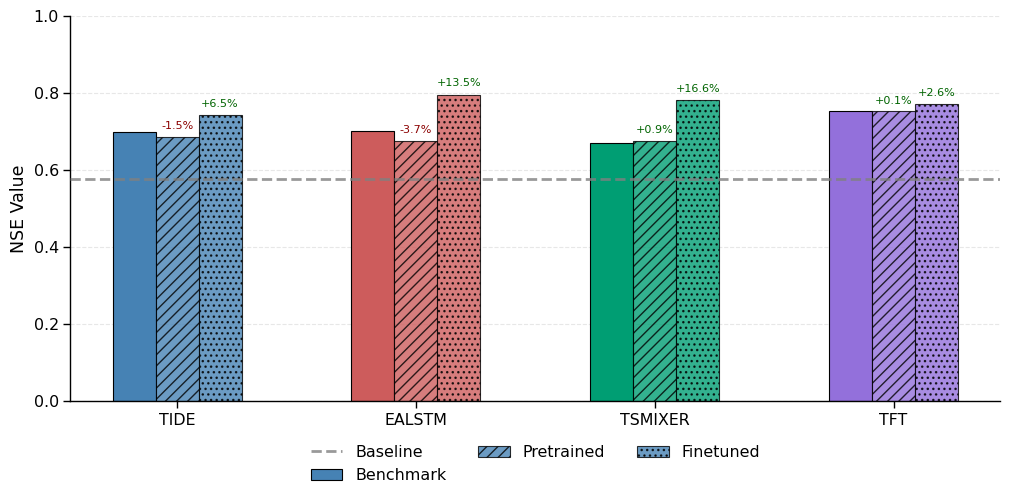

In [18]:
fig, ax = plot_horizon_performance_bars(
    results,
    horizon=10,
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "pretrained", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 5),
    with_whiskers=False,
    positive_is_better=True,
    dummy_model="dummy",
)
ax.set_ylim(0, 1)
sns.despine()
plt.show()


/var/folders/y6/kqwqph4s3sj7hkxryrly5y6r0000gn/T/ipykernel_70550/1011034160.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend().remove()


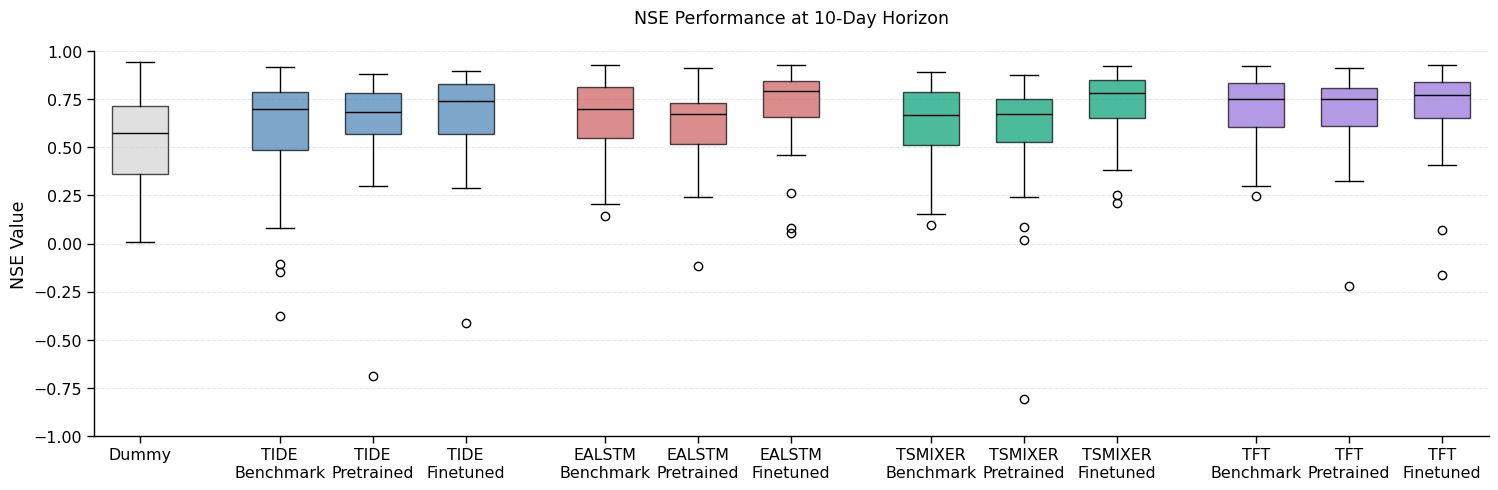

In [19]:
fig, ax = plot_horizon_performance_boxplots(
    results,
    horizon=10,
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "pretrained", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(18, 5),
    dummy_model="dummy",
)
# remove legend
ax.legend().remove()
ax.set_ylim(-1, 1)
sns.despine()
plt.show()


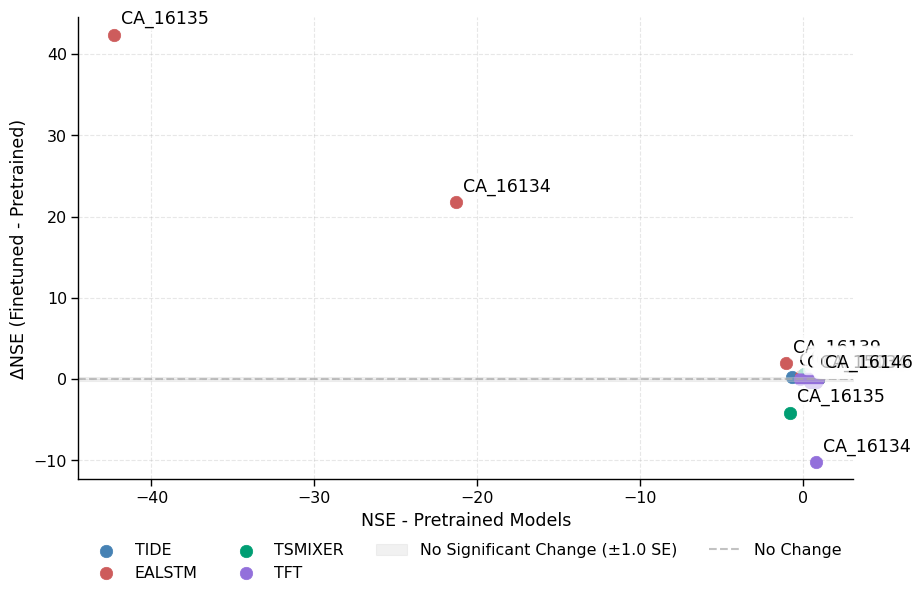

In [20]:
fig, ax = plot_basin_performance_scatter(
    results,
    benchmark_pattern="pretrained",
    challenger_pattern="finetuned",
    horizon=10,
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    metric="nse",
    figsize=(10, 6),
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    debug=True,
)
sns.despine()
plt.show()

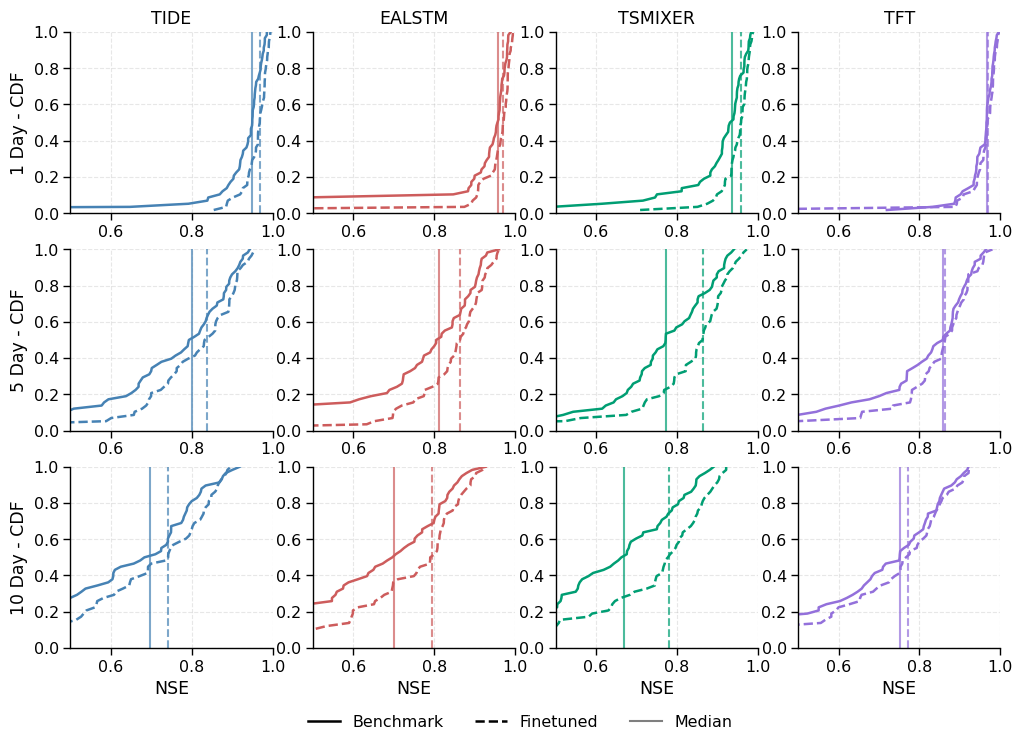

In [21]:
fig, axes = plot_model_cdf_grid(
    results,
    horizons=[1, 5, 10],
    metric="nse",
    architectures=["tide", "ealstm", "tsmixer", "tft"],
    variants=["benchmark", "finetuned"],
    colors={"tide": "#4682B4", "ealstm": "#CD5C5C", "tsmixer": "#009E73", "tft": "#9370DB"},
    figsize=(12, 8),
)
sns.despine()
plt.show()

In [22]:
# fig, ax = plot_rolling_forecast(
#     results,
#     model_name="tsmixer_finetuned",
#     gauge_id="CA_15016",
#     horizon=1,
#     figsize=(10, 5),
#     color_scheme={"observed": "#2E4057", "predicted": "#FF6B35"},
# )

# sns.despine()
# ax.set_xlabel("")
# ax.set_ylabel("Streamflow (mm/day)")

# plt.show()

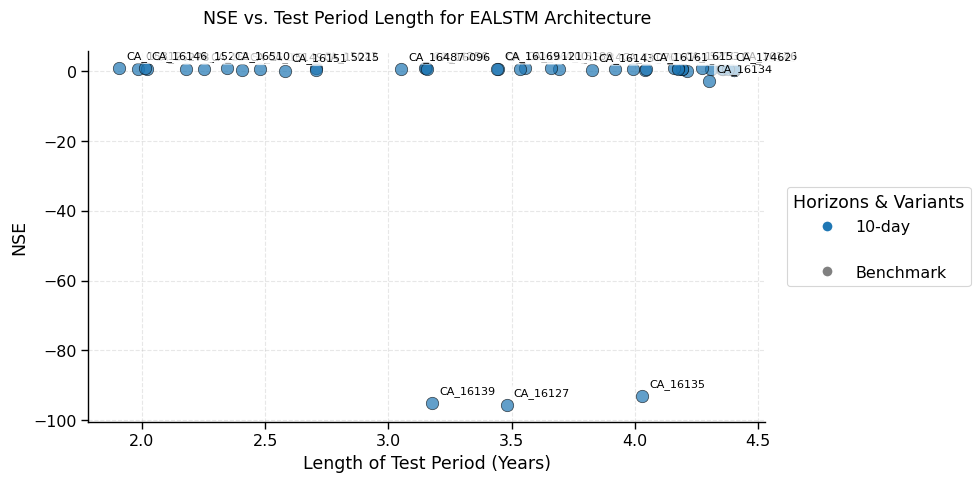

In [23]:
plot_performance_vs_test_length(
    results,
    architecture="ealstm",
    variants=["benchmark"],
    horizons=[10],
    metric="nse",
    figsize=(10, 5),
    debug=True,
)

sns.despine()
plt.show()

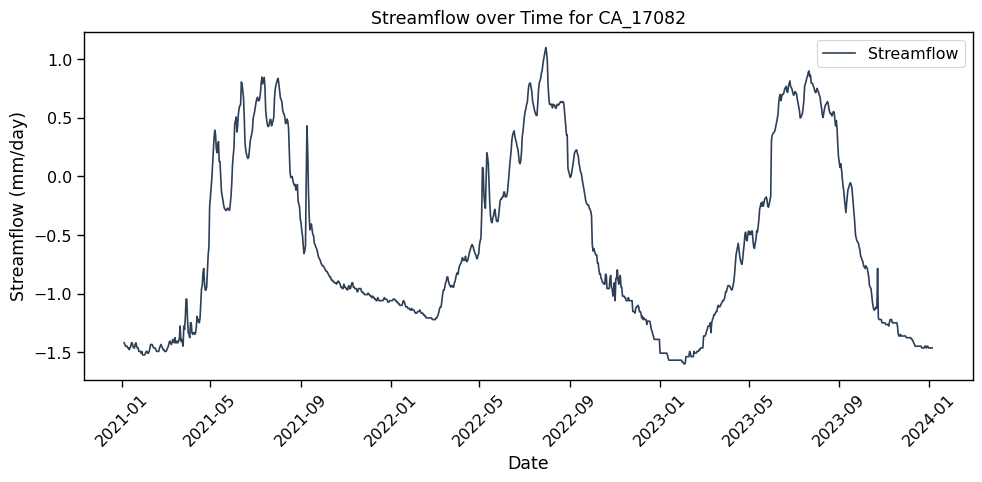

In [24]:
import pandas as pd

data = "/Users/cooper/Desktop/hydro-forecasting/tests/first_eval/e6a9396c-5a5e-5c0d-9aa7-2ee9cd109f78/processed_time_series/test/CA_17082.parquet"

df = pd.read_parquet(data)

# Plot streamflow agains date
plt.figure(figsize=(10, 5))
plt.plot(df["date"], df["streamflow"], label="Streamflow", color="#2E4057")
plt.xlabel("Date")
plt.ylabel("Streamflow (mm/day)")
plt.title("Streamflow over Time for CA_17082")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import polars as pl
from pathlib import Path
from typing import Dict


def get_test_set_lengths(datamodule) -> dict[str, int]:
    """
    Simple debugging function to get test set lengths for all gauge IDs.

    Args:
        datamodule: HydroInMemoryDataModule instance (after setup() has been called)

    Returns:
        Dictionary mapping gauge_id to number of test samples
    """
    test_lengths = {}
    datamodule.prepare_data()  # Ensure data is prepared
    datamodule.setup()  # Ensure setup is called to initialize datamodule

    # Check if datamodule has been properly set up
    if not hasattr(datamodule, "processed_time_series_dir") or datamodule.processed_time_series_dir is None:
        print("ERROR: DataModule not properly set up. Call prepare_data() and setup() first.")
        return test_lengths

    test_dir = datamodule.processed_time_series_dir / "test"

    if not test_dir.exists():
        print(f"ERROR: Test directory not found: {test_dir}")
        return test_lengths

    # Get all test basin IDs
    test_basin_ids = getattr(datamodule, "_test_basin_ids", [])

    if not test_basin_ids:
        print("WARNING: No test basin IDs found in datamodule.")
        # Try to infer from files in test directory
        test_basin_ids = [f.stem for f in test_dir.glob("*.parquet")]
        print(f"Found {len(test_basin_ids)} test files in directory.")

    print(f"Checking test set lengths for {len(test_basin_ids)} basins...")

    for gauge_id in test_basin_ids:
        test_file = test_dir / f"{gauge_id}.parquet"

        try:
            if test_file.exists():
                # Read the test file and count rows
                df = pl.read_parquet(test_file)
                test_lengths[gauge_id] = df.height
            else:
                print(f"WARNING: Test file not found for {gauge_id}")
                test_lengths[gauge_id] = 0

        except Exception as e:
            print(f"ERROR reading test file for {gauge_id}: {e}")
            test_lengths[gauge_id] = -1  # Indicate error

    return test_lengths


def print_test_set_summary(datamodule):
    """
    Print a summary of test set lengths.

    Args:
        datamodule: HydroInMemoryDataModule instance
    """
    test_lengths = get_test_set_lengths(datamodule)

    if not test_lengths:
        print("No test data found.")
        return

    # Calculate statistics
    valid_lengths = [length for length in test_lengths.values() if length > 0]

    if valid_lengths:
        min_length = min(valid_lengths)
        max_length = max(valid_lengths)
        avg_length = sum(valid_lengths) / len(valid_lengths)

        print(f"\n=== TEST SET SUMMARY ===")
        print(f"Total basins with test data: {len(valid_lengths)}")
        print(f"Min test set length: {min_length} samples")
        print(f"Max test set length: {max_length} samples")
        print(f"Average test set length: {avg_length:.1f} samples")
        print(f"Min test length in years: {min_length / 365.25:.2f} years")
        print(f"Max test length in years: {max_length / 365.25:.2f} years")
        print(f"Average test length in years: {avg_length / 365.25:.2f} years")

        # Show individual basin lengths (first 10 for brevity)
        print(f"\n=== INDIVIDUAL BASIN LENGTHS (first 10) ===")
        for i, (gauge_id, length) in enumerate(test_lengths.items()):
            if i >= 10:
                print(f"... and {len(test_lengths) - 10} more basins")
                break
            years = length / 365.25 if length > 0 else 0
            print(f"{gauge_id}: {length} samples ({years:.2f} years)")
    else:
        print("No valid test data found.")



test_lengths = get_test_set_lengths(ealstm_data_module)
print_test_set_summary(ealstm_data_module)

2025-06-17 16:33:36,876 - hydro_forecasting.data.in_memory_datamodule - INFO - Starting data preparation...
2025-06-17 16:33:36,877 - hydro_forecasting.data.in_memory_datamodule - INFO - Generated Run UUID for current config: 0928e934-70dd-5f09-b507-2976440067bd
2025-06-17 16:33:36,877 - hydro_forecasting.data.in_memory_datamodule - INFO - Checking for existing processed data at: /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/0928e934-70dd-5f09-b507-2976440067bd
2025-06-17 16:33:36,990 - hydro_forecasting.data.in_memory_datamodule - INFO - Successfully validated and prepared to reuse data from /Users/cooper/Desktop/hydro-forecasting/tests/first_eval/0928e934-70dd-5f09-b507-2976440067bd
2025-06-17 16:33:36,991 - hydro_forecasting.data.in_memory_datamodule - INFO - Reusing existing processed data from run_uuid: 0928e934-70dd-5f09-b507-2976440067bd
2025-06-17 16:33:36,991 - hydro_forecasting.data.in_memory_datamodule - INFO - Loaded 3 pipelines and data for 58 basins from reused

Checking test set lengths for 58 basins...
Checking test set lengths for 58 basins...

=== TEST SET SUMMARY ===
Total basins with test data: 58
Min test set length: 1008 samples
Max test set length: 1919 samples
Average test set length: 1657.4 samples
Min test length in years: 2.76 years
Max test length in years: 5.25 years
Average test length in years: 4.54 years

=== INDIVIDUAL BASIN LENGTHS (first 10) ===
CA_15013: 1849 samples (5.06 years)
CA_15020: 1842 samples (5.04 years)
CA_15022: 1299 samples (3.56 years)
CA_15025: 1842 samples (5.04 years)
CA_15034: 1660 samples (4.54 years)
CA_15039: 1919 samples (5.25 years)
CA_15040: 1919 samples (5.25 years)
CA_15044: 1901 samples (5.20 years)
CA_15045: 1919 samples (5.25 years)
CA_15054: 1133 samples (3.10 years)
... and 48 more basins
